Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [108]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.simplefilter('ignore')

In [109]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [110]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r'C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
data_dir_test = pathlib.Path(r'C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [111]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [112]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [113]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [114]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [115]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = np.array(train_ds.class_names)
print(class_names)

['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [116]:
import matplotlib.pyplot as plt

image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(data_dir_train, 
                                              target_size=(img_height, img_width), 
                                              class_mode="categorical", 
                                              shuffle=True, 
                                              batch_size=batch_size)

Found 6739 images belonging to 9 classes.


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [117]:
image_batch, label_batch = next(iter(train_data_gen))

In [118]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        # plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

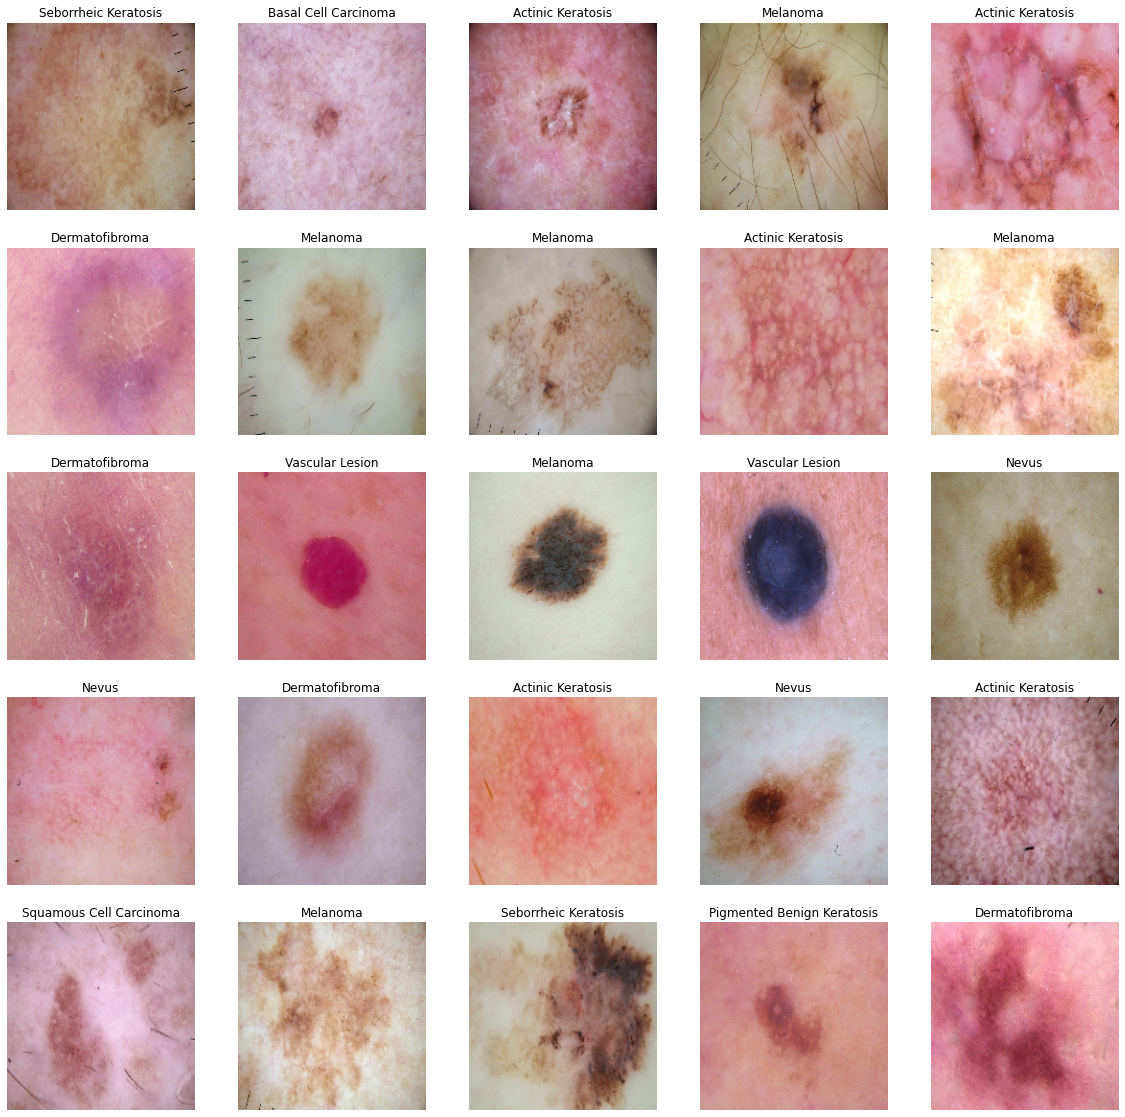

In [119]:
show_batch(image_batch, label_batch)

#The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of 
#shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), 
#these are corresponding labels to the 32 images.

In [120]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [121]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [122]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [123]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [124]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [125]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 67s 336ms/step - loss: 1.8489 - accuracy: 0.3045 - val_loss: 1.4090 - val_accuracy: 0.4662
Epoch 2/20
169/169 [==============================] - 58s 341ms/step - loss: 1.3413 - accuracy: 0.4954 - val_loss: 1.2906 - val_accuracy: 0.5464
Epoch 3/20
169/169 [==============================] - 53s 316ms/step - loss: 1.1134 - accuracy: 0.5886 - val_loss: 1.1435 - val_accuracy: 0.5880
Epoch 4/20
169/169 [==============================] - 56s 331ms/step - loss: 0.9320 - accuracy: 0.6619 - val_loss: 0.9118 - val_accuracy: 0.6927
Epoch 5/20
169/169 [==============================] - 55s 327ms/step - loss: 0.7526 - accuracy: 0.7337 - val_loss: 0.8907 - val_accuracy: 0.7030
Epoch 6/20
169/169 [==============================] - 54s 319ms/step - loss: 0.5968 - accuracy: 0.7834 - val_loss: 0.7047 - val_accuracy: 0.7632
Epoch 7/20
169/169 [==============================] - 55s 324ms/step - loss: 0.4610 - accuracy: 0.8361 - val_loss: 0.7284 - val_ac

### Visualizing training results

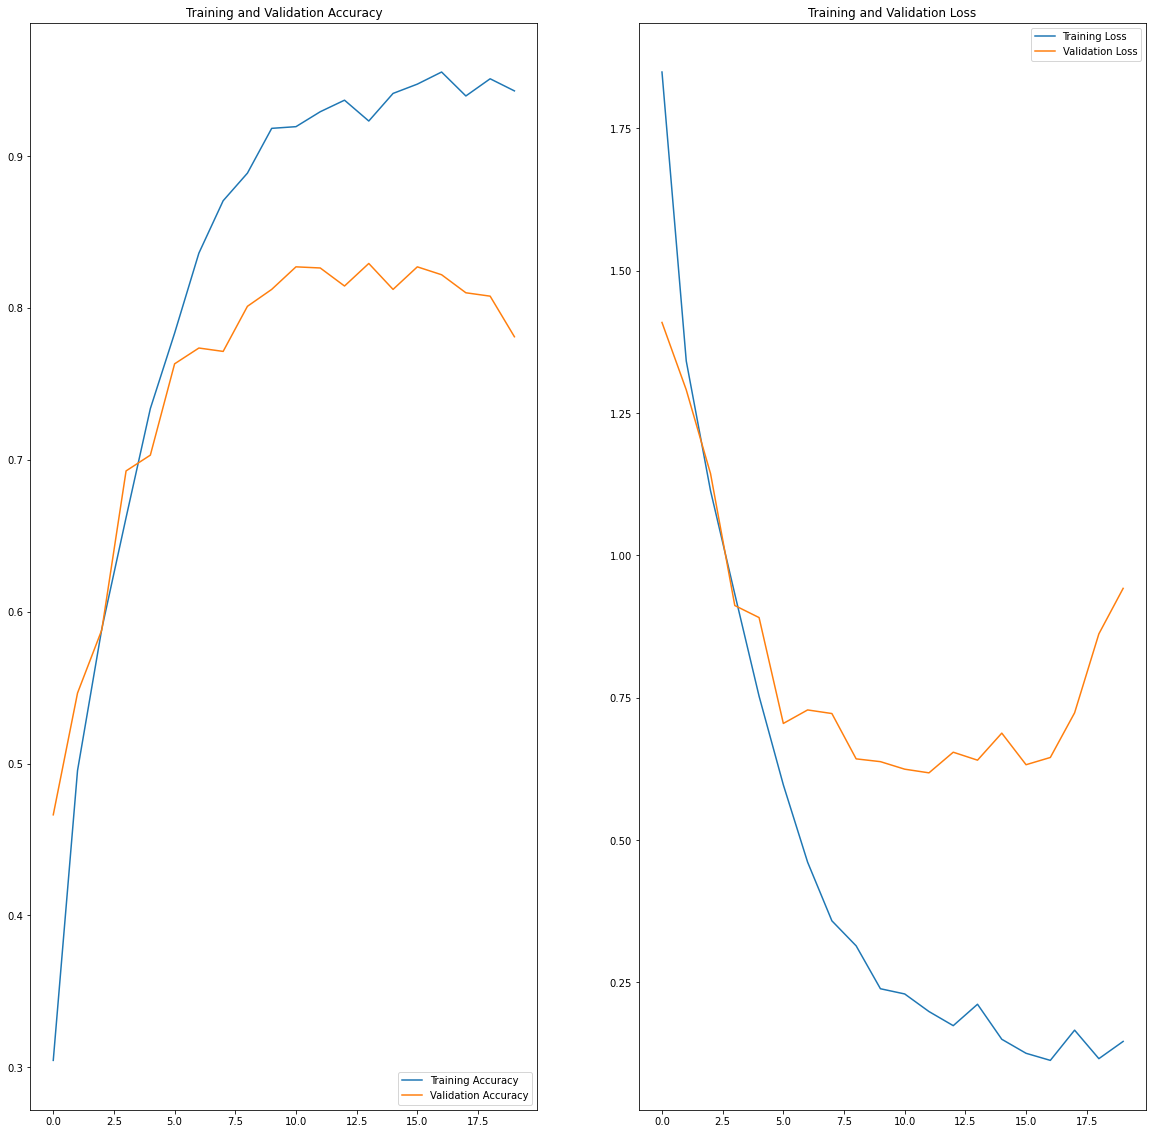

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [127]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

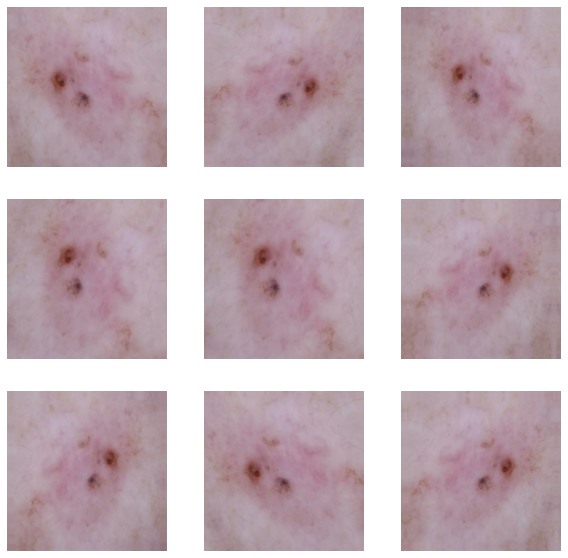

In [128]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

#augumented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [129]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_2= Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [130]:
## Your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [131]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [132]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 63s 354ms/step - loss: 1.8969 - accuracy: 0.2923 - val_loss: 1.5190 - val_accuracy: 0.4291
Epoch 2/20
169/169 [==============================] - 59s 349ms/step - loss: 1.4846 - accuracy: 0.4368 - val_loss: 1.4223 - val_accuracy: 0.4551
Epoch 3/20
169/169 [==============================] - 59s 352ms/step - loss: 1.3663 - accuracy: 0.4707 - val_loss: 1.3252 - val_accuracy: 0.4766
Epoch 4/20
169/169 [==============================] - 59s 350ms/step - loss: 1.2553 - accuracy: 0.5267 - val_loss: 1.2522 - val_accuracy: 0.5197
Epoch 5/20
169/169 [==============================] - 59s 352ms/step - loss: 1.2086 - accuracy: 0.5399 - val_loss: 1.2345 - val_accuracy: 0.5308
Epoch 6/20
169/169 [==============================] - 60s 357ms/step - loss: 1.1529 - accuracy: 0.5655 - val_loss: 1.0718 - val_accuracy: 0.5932
Epoch 7/20
169/169 [==============================] - 71s 419ms/step - loss: 1.0617 - accuracy: 0.6013 - val_loss: 1.0103 - val_ac

### Visualizing the results

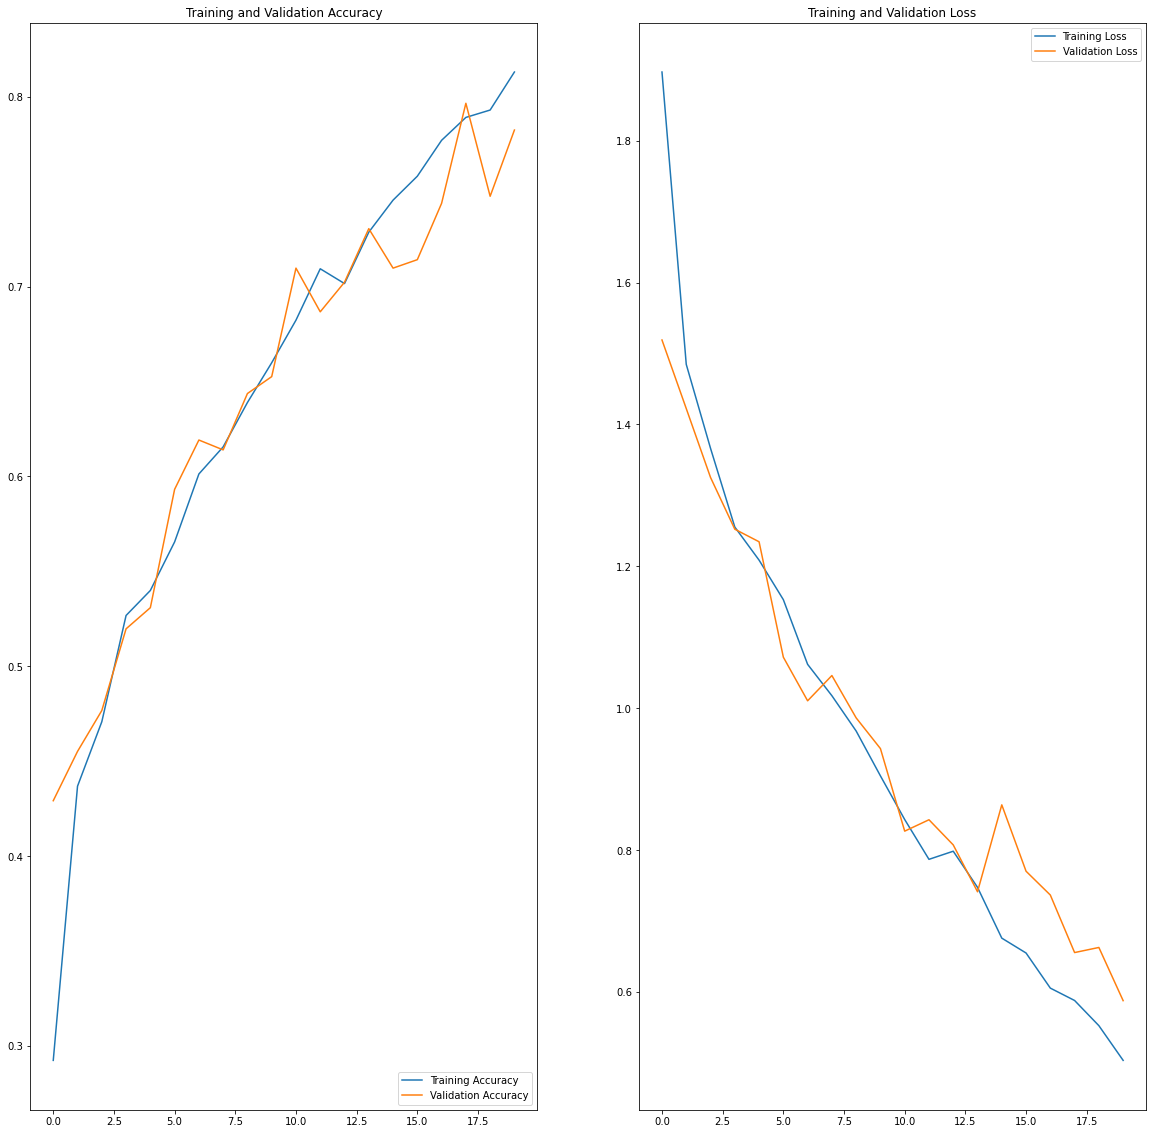

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is some improvement seen

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [134]:
## Your code goes here.

from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [135]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,actinic keratosis
1,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,actinic keratosis
2,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,actinic keratosis
3,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,actinic keratosis
4,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,actinic keratosis
...,...,...
2234,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,vascular lesion
2235,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,vascular lesion
2236,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,vascular lesion
2237,C:\Users\Samya\Downloads\Skin cancer ISIC The ...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


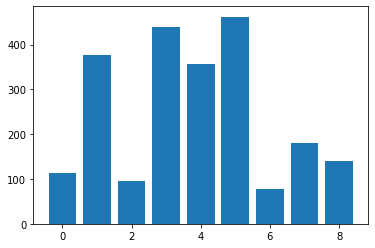

In [136]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? class 6
#### - Which classes dominate the data in terms proportionate number of samples? class 1


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [144]:
!pip install Augmentor

In [145]:
class_names

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [151]:
path_to_training_dataset=r'C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2608E336F48>: 100%|█| 500/500 [00:02<00:00, 175.79 Samples


Initialised with 376 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2608E4A6048>: 100%|█| 500/500 [00:03<00:00, 162.72 Samples


Initialised with 95 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26091C8F608>: 100%|█| 500/500 [00:03<00:00, 163.68 Samples


Initialised with 438 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x260865C9948>: 100%|█| 500/500 [00:14<00


Initialised with 357 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x2608FF1C708>: 100%|█| 500/500 [00:13<00:00, 36.02 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26091DEA9C8>: 100%|█| 500/500 [00:03<00:00, 165.62 Samples


Initialised with 77 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2608E3452C8>: 100%|█| 500/500 [00:06<00:00, 72.87 Samples


Initialised with 181 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26091DD3808>: 100%|█| 500/500 [00:03<00:00, 158.35 Samples


Initialised with 139 image(s) found.
Output directory set to C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26083CEECC8>: 100%|█| 500/500 [00:03<00:00, 157.75 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [152]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train_aug = pathlib.Path(r"C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
#data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test")#

In [153]:
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train)

18000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [154]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\Samya\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_01cf9856-32a7-4c8d-a8b0-f43bdda6c238.jpg',
 'C:\\Users\\Samya\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0fd21785-59fb-43a6-a16f-7a4c31559797.jpg',
 'C:\\Users\\Samya\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_17ad83c7-18e4-4109-8e41-15ac38a6e30e.jpg',
 'C:\\Users\\Samya\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_43fed837-8d24-4707-9895-0daf8d8b73a9.jpg',
 'C:\\Users\\Samya\\Downloads\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic kera

In [156]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
# lesion_list_new

TypeError: 'module' object is not callable

In [ ]:
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [ ]:
# new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [157]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [158]:
#data_dir_train="path to directory with training data + data created using augmentor"

data_dir_train=r'C:\Users\Samya\Downloads\Skin cancer ISIC The International Skin Imaging Collaboration\Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


#### **Todo:** Create a validation dataset

In [159]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [160]:
## your code goes here

model_3= Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [161]:
## your code goes here

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [162]:
epochs = 30
## Your code goes here, use 50 epochs.
history = history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/30
506/506 [==============================] - 229s 453ms/step - loss: 0.5978 - accuracy: 0.7840 - val_loss: 0.4161 - val_accuracy: 0.8525
Epoch 2/30
506/506 [==============================] - 227s 448ms/step - loss: 0.5002 - accuracy: 0.8148 - val_loss: 0.3460 - val_accuracy: 0.8745
Epoch 3/30
506/506 [==============================] - 227s 447ms/step - loss: 0.4394 - accuracy: 0.8365 - val_loss: 0.3311 - val_accuracy: 0.8831
Epoch 4/30
506/506 [==============================] - 229s 451ms/step - loss: 0.4046 - accuracy: 0.8507 - val_loss: 0.2901 - val_accuracy: 0.9021
Epoch 5/30
506/506 [==============================] - 209s 413ms/step - loss: 0.3918 - accuracy: 0.8540 - val_loss: 0.3080 - val_accuracy: 0.8952
Epoch 6/30
506/506 [==============================] - 207s 408ms/step - loss: 0.3518 - accuracy: 0.8693 - val_loss: 0.3310 - val_accuracy: 0.8782
Epoch 7/30
506/506 [==============================] - 197s 389ms/step - loss: 0.3651 - accuracy: 0.8651 - val_loss: 0.2536 -

#### **Todo:**  Visualize the model results

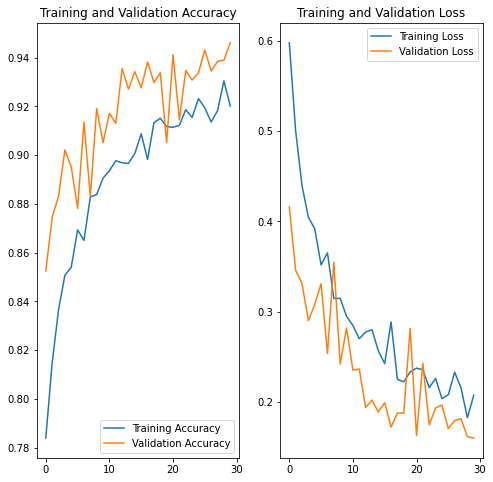

In [163]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help? 

Underfitting/Overfitting is not present anymore. The result looks pretty good.